In [1]:
from matplotlib import pyplot as plt
from itertools import product
# import seaborn as sns
import pandas as pd
import os.path as op
import argparse
import re
import numpy as np
import matplotlib.pyplot as plt
import mne
import seaborn as sns
from scipy import signal
from scipy.fft import fftshift
from bids import BIDSLayout
from statsmodels.stats.anova import AnovaRM

from util.io.ffr import *

In [ ]:
# og_evokeds = pd.read_csv('evokeds.csv')

In [98]:
evokeds = og_evokeds
evokeds['uV'] = evokeds['uV'] * 1000000
# BADS = [2, 3, 6, 11, 33, 34, 37]
BADS = [2, 3, 6, 33, 37]

for bad in BADS:
    evokeds = evokeds[evokeds['sub'] != bad]
np.unique(evokeds['sub'])

array([ 4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40,
       41])

<Axes: xlabel='tone', ylabel='uV'>

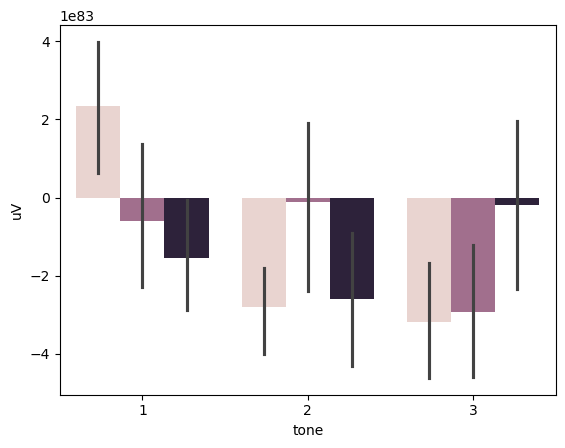

In [99]:
mean_evokeds = evokeds[evokeds.chan == 'Cz']
seg_target = mean_evokeds[mean_evokeds.msec == 420]
seg_target = seg_target.groupby(['sub', 'tone', 'target'], as_index=False)['uV'].mean()
seg_target
sns.barplot(seg_target, x="tone", y="uV", hue="target", legend=False)

<Axes: xlabel='tone', ylabel='uV'>

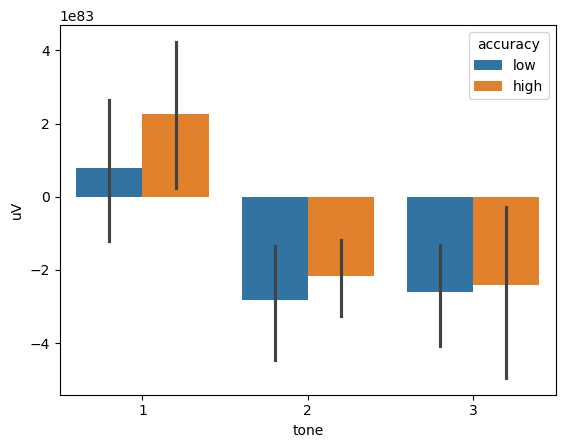

In [100]:
mean_evokeds = evokeds[evokeds.target == 1]
seg_target = mean_evokeds[mean_evokeds.msec == 420]
seg_target = seg_target.groupby(['sub', 'tone', 'accuracy'], as_index=False)['uV'].mean()
seg_target
sns.barplot(seg_target, x="tone", y="uV", hue="accuracy")

<Axes: xlabel='tone', ylabel='uV'>

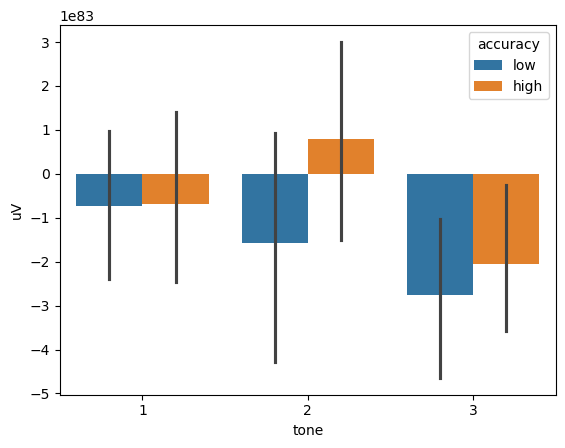

In [107]:
mean_evokeds = evokeds[evokeds.target == 2]
seg_target = mean_evokeds[mean_evokeds.msec == 420]
seg_target = seg_target.groupby(['sub', 'tone', 'accuracy'], as_index=False)['uV'].mean()
seg_target
sns.barplot(seg_target, x="tone", y="uV", hue="accuracy")

<Axes: xlabel='tone', ylabel='uV'>

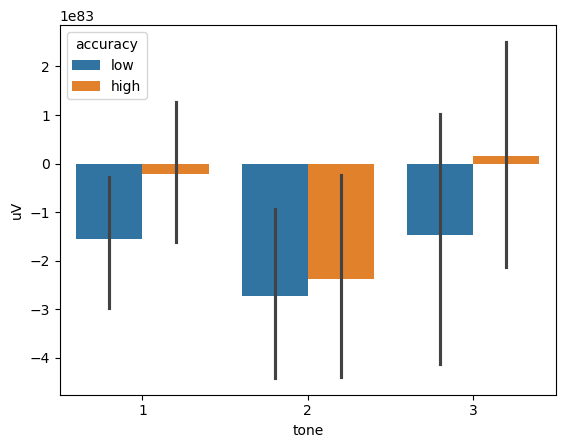

In [102]:
mean_evokeds = evokeds[evokeds.target == 3]
seg_target = mean_evokeds[mean_evokeds.msec == 420]
seg_target = seg_target.groupby(['sub', 'tone', 'accuracy'], as_index=False)['uV'].mean()
seg_target
sns.barplot(seg_target, x="tone", y="uV", hue="accuracy")

In [12]:
evokeds = pd.read_csv('evokeds.csv')
evokeds['uV'] = evokeds['uV'] * 1000000
evokeds

,sub,chan,predictable,target,tone,accuracy,msec,uV
0,2,Cz,True,1,1,low,-173,-0.536844
1,2,Cz,True,1,1,low,-172,-0.577931
2,2,Cz,True,1,1,low,-171,-0.668235
3,2,Cz,True,1,1,low,-170,-0.766571
4,2,Cz,True,1,1,low,-169,-0.888384
...,...,...,...,...,...,...,...,...
2488495,41,Pz,False,3,3,high,522,0.559256
2488496,41,Pz,False,3,3,high,523,0.548920
2488497,41,Pz,False,3,3,high,524,0.543589
2488498,41,Pz,False,3,3,high,525,0.536760


(-50.0, 500.0)

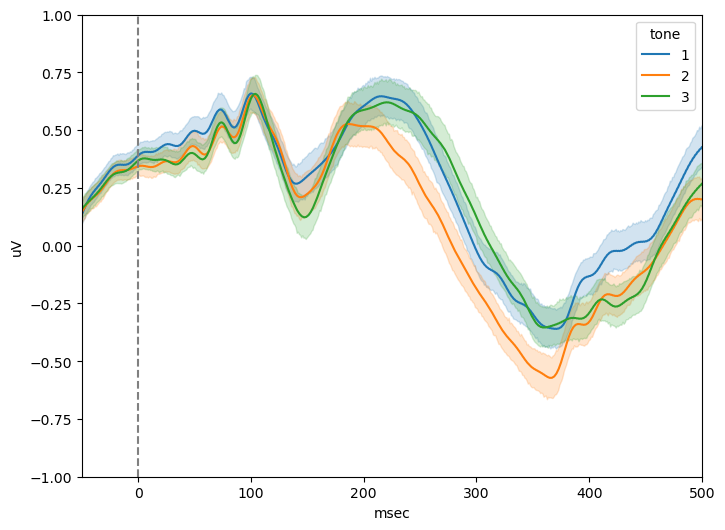

In [13]:
evokeds_Cz = evokeds[evokeds.chan == 'Cz']
evokeds_Cz = evokeds_Cz.groupby(['sub', 'tone', 'msec', 'uV'], as_index = False)['uV'].mean()
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_Cz, x = "msec", y = "uV", hue = "tone", palette = 'tab10', ax = ax)
graph.axvline(0, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_ylim(-1, 1)
graph.set_xlim(-50, 500)

#### Grand average ERP

(-50.0, 500.0)

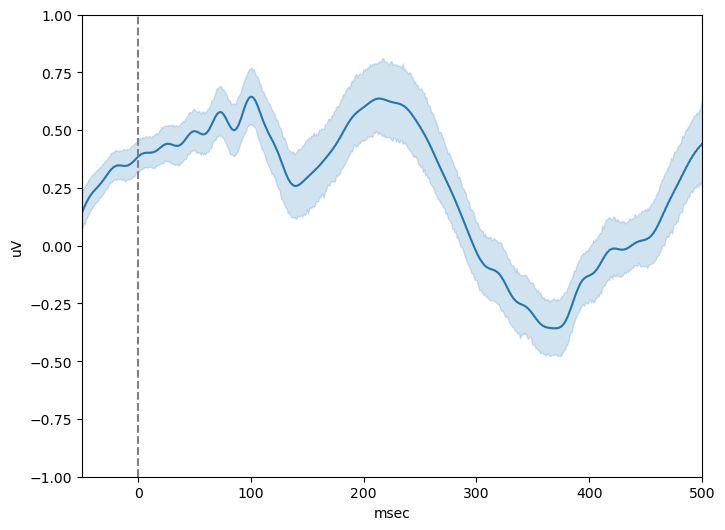

In [14]:
evokeds_Cz = evokeds[evokeds.chan == 'Cz']
evokeds_Cz = evokeds_Cz[evokeds_Cz.tone == 1]
evokeds_Cz = evokeds_Cz.groupby(['sub', 'msec'], as_index = False)['uV'].mean()
rrfig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_Cz, x = "msec", y = "uV", ax = ax)
graph.axvline(0, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_ylim(-1, 1)
graph.set_xlim(-50, 500)

**Calculate a peak for sanity check**

In [15]:
# Keep only Cz
mean_evokeds = evokeds[evokeds.chan == 'Cz']
mean_evokeds = mean_evokeds[mean_evokeds.tone == 1]

# Average over all subjects and other conditions the time domain (i.e. the dark line)
mean_evokeds_tone = mean_evokeds.groupby(['msec'], as_index=False)['uV'].mean()

# Take a time slice
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 80]
seg_tone = seg_tone[seg_tone.msec < 130]

# Find the max value within that time slice
print(f'Max of grand average ERP for tone 1: {max(seg_tone.uV)}')

Max of grand average ERP for tone 1: 0.6593091800859565


**Plot**

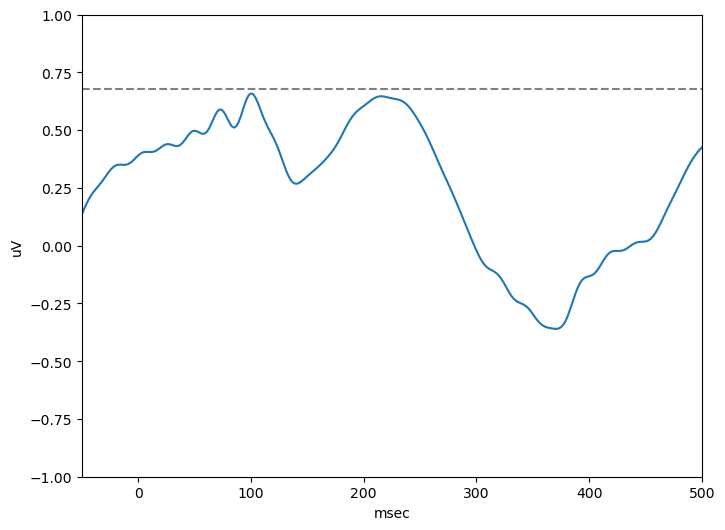

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(mean_evokeds_tone, x = "msec", y = "uV")
graph.set_xlim(-50, 500)
graph.set_ylim(-1, 1)
graph.axhline(0.6804, linestyle = 'dashed', color = 'gray')

#### Subject ERP

In [17]:
# Keep only Cz
mean_evokeds = evokeds[evokeds.chan == 'Cz']
mean_evokeds = mean_evokeds[mean_evokeds.tone == 1]

# Average over other conditions in the time domain to get ERPs for each subject
mean_evokeds_tone = mean_evokeds.groupby(['sub', 'msec'], as_index=False)['uV'].mean()

# Take a time slice
seg_tone = mean_evokeds_tone[mean_evokeds_tone.msec > 80]
seg_tone = seg_tone[seg_tone.msec < 130]

# Calculate the max for each subject
sub_max = seg_tone.groupby(['sub'], as_index = False)['uV'].max()

# Take the mean of the maxs, it won't be the same
print(f'Mean of subject maxs for tone 1: {np.mean(sub_max.uV)}')

Mean of subject maxs for tone 1: 0.7376932878419517


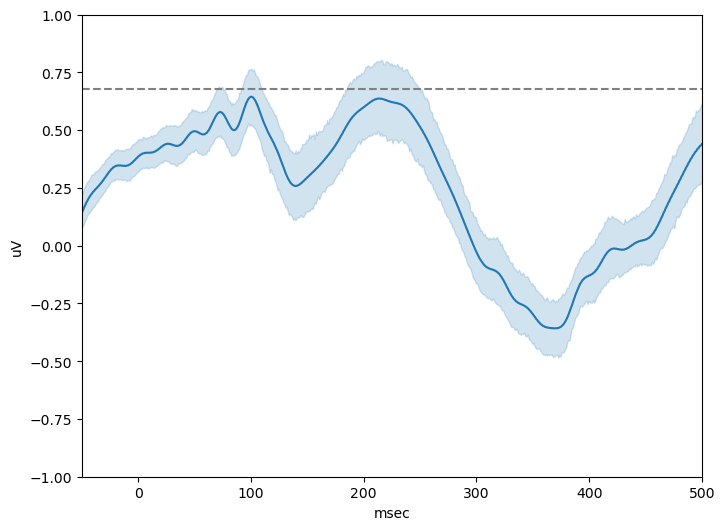

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(mean_evokeds_tone, x = "msec", y = "uV")
graph.set_xlim(-50, 500)
graph.set_ylim(-1, 1)
graph.axhline(0.6804, linestyle = 'dashed', color = 'gray')

In [19]:
# evokeds_Cz
# mean_evokeds_tone = evokeds_Cz.groupby(['tone', 'msec'], as_index=False)['uV'].mean()

# Take only Cz channel
evokeds_Cz = evokeds[evokeds.chan == 'Cz']

# Segment 
seg_tone = evokeds_Cz[evokeds_Cz.msec > 80]
seg_tone = seg_tone[seg_tone.msec < 130]

# Take mean in time domain
seg_tone = seg_tone.groupby(['sub', 'tone', 'msec'], as_index = False)['uV'].mean()

# Take the max for each subject
sub_max = seg_tone.groupby(['sub', 'tone'], as_index = False)['uV'].max()

# Take only one tone
max_tone = sub_max[sub_max.tone == 1]
print(np.mean(max_tone.uV))
max_tone = sub_max[sub_max.tone == 2]
print(np.mean(max_tone.uV))
max_tone = sub_max[sub_max.tone == 3]
print(np.mean(max_tone.uV))

# Take mean 
# np.mean(max_tone.uV)



# seg_tone
# max_sub = seg_tone.groupby(['sub', 'tone'], as_index = False)['uV'].max()
# max_sub
# np.average(max_sub)

# # Tone 1
# print(f'Max tone 1: {max(seg_tone.uV[seg_tone.tone == 1])}')
# # Tone 2
# print(f'Max tone 2: {max(seg_tone.uV[seg_tone.tone == 2])}')
# # Tone 3
# print(f'Max tone 3: {max(seg_tone.uV[seg_tone.tone == 3])}')

0.7376932878419517
0.7649892988791586
0.7833589997917441


In [20]:
evokeds_Cz = evokeds[evokeds.chan == 'Cz']
evokeds_Cz = evokeds_Cz.groupby(['sub', 'tone', 'msec', 'uV'], as_index = False)['uV'].mean()
evokeds_Cz

,sub,tone,msec,uV
0,2,1,-173,-0.832348
1,2,1,-173,-0.634929
2,2,1,-173,-0.561596
3,2,1,-173,-0.536844
4,2,1,-173,-0.305879
...,...,...,...,...
497695,41,3,526,0.882720
497696,41,3,526,1.062977
497697,41,3,526,1.360109
497698,41,3,526,1.965208


<Axes: xlabel='msec', ylabel='uV'>

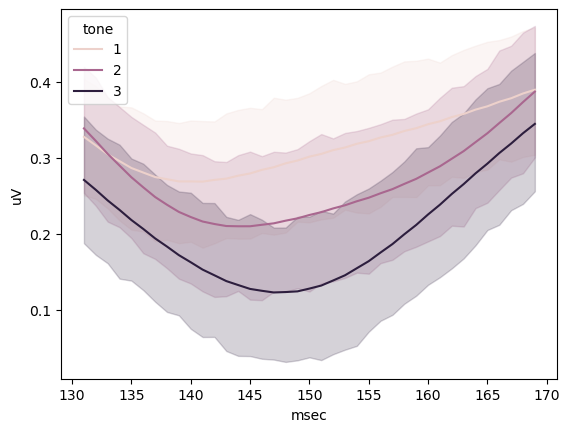

In [21]:
seg_tone = evokeds_Cz[evokeds_Cz.msec > 130]
seg_tone = seg_tone[seg_tone.msec < 170]
sns.lineplot(data = seg_tone, x = "msec", y = "uV", hue = "tone")

In [22]:
# evokeds_tone_2 = evokeds_Cz[evokeds_Cz.tone == 2]
seg_tone = evokeds_Cz[evokeds_Cz.msec > 80]
seg_tone = seg_tone[seg_tone.msec < 130]


# # Take max for each subject
# max_sub = seg_tone.groupby(['sub', 'tone'], as_index = False)['uV'].max()
# print(max_sub)

# # Then take mean
# np.average(max_sub.uV)

In [23]:
seg_tone

,sub,tone,msec,uV
1524,2,1,81,-0.193405
1525,2,1,81,-0.048464
1526,2,1,81,0.087168
1527,2,1,81,0.625044
1528,2,1,81,1.196979
...,...,...,...,...
495313,41,3,129,0.495821
495314,41,3,129,0.537850
495315,41,3,129,0.551376
495316,41,3,129,0.575842
